# Play around with Pandas to read CSV

In [4]:
import pandas as pd
import numpy as np
from scipy import misc
from PIL import Image
from IPython.display import display
from six.moves import cPickle as pickle
import os

In [5]:
# Read face emotion dataset
data_path = "../datasets/fer2013/fer2013.csv"

In [6]:
fer2013 = pd.read_csv(data_path)

FileNotFoundError: File b'../datasets/fer2013/fer2013.csv' does not exist

In [6]:
print('Total length:', len(fer2013))

('Total length:', 35887)


In [9]:
print('Training length:', len(fer2013[fer2013['Usage'] == 'Training']))

('Training length:', 28709)


In [ ]:
print 

In [104]:
private_test = fer2013[fer2013['Usage'] == 'PrivateTest']
len(public_test)

3589

In [102]:
public_test = fer2013[fer2013['Usage'] == 'PublicTest']
len(pub)

3589

In [15]:
fer2013['emotion'][0] + 1

1

In [91]:
img0_string = fer2013['pixels'][60]

In [92]:
img0_array = np.fromstring(str(img0_string), dtype=np.uint8, sep=' ').reshape((48,48))

In [93]:
img0_array[0,0]

120

In [94]:
# Convert Gray to RGB
img0_image = Image.fromarray(img0_array).convert('RGB')

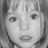

In [95]:
display(img0_image)

In [96]:
aa = np.array(img0_image)

In [97]:
aa.shape

(48, 48, 3)

In [98]:
aa[0,0,::-1]

array([120, 120, 120], dtype=uint8)

### Face detect and cropping

In [88]:
with tf.device("/cpu:0"):
    with tf.Graph().as_default():
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
        sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
        with sess.as_default():
            pnet, rnet, onet = align.detect_face.create_mtcnn(sess, './data/')

In [89]:
minsize = 20 # minimum size of face
threshold = [ 0.6, 0.7, 0.7 ]  # three steps's threshold
factor = 0.709 # scale factor


In [99]:
bounding_boxes, _ = align.detect_face.detect_face(aa, minsize, pnet, rnet, onet, threshold, factor)

In [100]:
bounding_boxes

array([[  5.22823304,  -1.7338475 ,  42.51308045,  48.77597088,
          0.97343034]])

In [34]:
img = aa

In [35]:
margin = 44
output_size = 48
det = bounding_boxes[:,0:4]
img_size = np.asarray(img.shape)[0:2]
det = np.squeeze(det)
bb = np.zeros(4, dtype=np.int32)
bb[0] = np.maximum(det[0]-margin/2, 0)
bb[1] = np.maximum(det[1]-margin/2, 0)
bb[2] = np.minimum(det[2]+margin/2, img_size[1])
bb[3] = np.minimum(det[3]+margin/2, img_size[0])
cropped = img[bb[1]:bb[3],bb[0]:bb[2],:]
scaled = misc.imresize(cropped, (output_size, output_size), interp='bilinear')

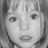

In [36]:
display(Image.fromarray(scaled))

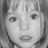

In [37]:
display(Image.fromarray(cropped))

In [38]:
cropped.shape


(48, 48, 3)

### Test with another image

In [39]:
mm = misc.imread('../manh.jpg')

In [40]:
mm.shape

(1365, 2048, 3)

In [41]:
bounding_boxes, _ = align.detect_face.detect_face(mm, minsize, pnet, rnet, onet, threshold, factor)

In [44]:
bounding_boxes
img = mm

In [45]:
margin = 44
output_size = 48
det = bounding_boxes[:,0:4]
img_size = np.asarray(img.shape)[0:2]
det = np.squeeze(det)
bb = np.zeros(4, dtype=np.int32)
bb[0] = np.maximum(det[0]-margin/2, 0)
bb[1] = np.maximum(det[1]-margin/2, 0)
bb[2] = np.minimum(det[2]+margin/2, img_size[1])
bb[3] = np.minimum(det[3]+margin/2, img_size[0])
cropped = img[bb[1]:bb[3],bb[0]:bb[2],:]
scaled = misc.imresize(cropped, (output_size, output_size), interp='bilinear')

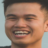

In [46]:
display(Image.fromarray(scaled))

## Make datasets

In [42]:
def make_arrays(nb_rows, image_size):
    if nb_rows > 0:
        dataset = np.ndarray((nb_rows, image_size, image_size), dtype=np.float32)
        labels = np.ndarray((nb_rows), dtype=np.int32)
    else:
        return None, None
    
    return dataset, labels

In [80]:
def pandas_csv_to_numpy(csv_dataframe, image_size = 48):
    rows = len(csv_dataframe['Usage'])
    dataset, labels = make_arrays(rows, image_size)
    for i in range(rows):
        row = csv_dataframe[i:i+1]
        labels[i] = row.values[0,0]
        pixel_string = str(row.values[0,1])
        image_data = np.fromstring(pixel_string, dtype=np.float32, sep=' ').reshape((image_size, image_size))
        dataset[i,:,:] = image_data
    return dataset, labels
        

In [105]:
train_dataset, train_labels = pandas_csv_to_numpy(fer2013[fer2013['Usage'] == 'Training'])
test_dataset, test_labels = pandas_csv_to_numpy(fer2013[fer2013['Usage'] == 'PublicTest'])
valid_dataset, valid_labels = pandas_csv_to_numpy(fer2013[fer2013['Usage'] == 'PrivateTest'])

In [106]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [110]:
pickle_file = 'fer2013.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [112]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

('Compressed pickle size:', 330878577)


In [113]:
train_dataset.shape

(28709, 48, 48)